## 1 — Imports

In [1]:
import os
import json
from pathlib import Path
from typing import Dict, List, Tuple, Any

import numpy as np
import pandas as pd

import optuna

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from sklearn.neural_network import MLPRegressor

import matplotlib.pyplot as plt


optuna.logging.set_verbosity(optuna.logging.WARNING)

import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)


C:\Users\paolo\AppData\Roaming\Python\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 2 — Settings, paths, output dirs

In [2]:
DATA_DIR = Path(".")

DATA_PATHS = {
    "EN<->ES": "final_en_es_2.csv",
    "EN<->IT": "final_en_it_2.csv",
    "EN<->PT": "final_en_pt_2.csv",
}

SIDES_TO_RUN = ["src", "tgt"]


USE_LOG1P_TARGET = True


OUTER_K = 5
INNER_K = 5
N_REPEATS = 1  


RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


N_TRIALS = 50


OUT_DIR = Path("rq2_mlp_cross_outputs")
OUT_DIR.mkdir(parents=True, exist_ok=True)

PLOTS_DIR = OUT_DIR / "plots"
PLOTS_DIR.mkdir(parents=True, exist_ok=True)

STUDIES_DIR = OUT_DIR / "optuna_studies"
STUDIES_DIR.mkdir(parents=True, exist_ok=True)

RESULTS_DIR = OUT_DIR / "results"
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

VERBOSE = True

results_store: List[Dict[str, Any]] = []


## 3 — Feature lists (CROSS-DIRECTION CONCAT)

In [3]:
def crossdirection_feature_lists() -> Tuple[List[str], List[str]]:
    numeric = [
        "src_lemma_length",
        "src_lexeme_count",
        "src_session_count",
        "tgt_lemma_length",
        "tgt_lexeme_count",
        "tgt_session_count",
        "frequency",
        "concreteness",
    ]
    categorical = [
        "src_pos",
        "tgt_pos",
        "semantic_field",
    ]
    return numeric, categorical


## 4 — Preprocessing and utilities

In [4]:
def load_pair(pair_label: str) -> pd.DataFrame:
    path = DATA_DIR / DATA_PATHS[pair_label]
    df = pd.read_csv(path)
    return df

def get_target(df: pd.DataFrame, side: str) -> np.ndarray:
    y = df[f"{side}_median_hf_days"].to_numpy(dtype=float)
    if USE_LOG1P_TARGET:
        y = np.log1p(y)
    return y

def compute_metrics(y_true: np.ndarray, y_pred: np.ndarray) -> Dict[str, float]:
    rmse = float(np.sqrt(mean_squared_error(y_true, y_pred)))
    mae = float(mean_absolute_error(y_true, y_pred))
    r2 = float(r2_score(y_true, y_pred))
    return {"rmse": rmse, "mae": mae, "r2": r2}

def check_required_columns(df: pd.DataFrame, cols: List[str], context: str = ""):
    missing = [c for c in cols if c not in df.columns]
    if missing:
        raise ValueError(f"Missing columns {missing} in {context}")

def make_preprocessor(
    numeric_features: List[str],
    categorical_features: List[str],
):
    
    
    num_transformer = Pipeline(steps=[("scaler", StandardScaler())])

    cat_transformer = OneHotEncoder(
        handle_unknown="ignore",
        sparse_output=False
    )

    pre = ColumnTransformer(
        transformers=[
            ("num", num_transformer, numeric_features),
            ("cat", cat_transformer, categorical_features),
        ],
        remainder="drop"
    )
    return pre


## 5 — MLP param space + model builder

In [5]:
HIDDEN_CHOICES_STR = [
    "64",
    "128",
    "256",
    "128_64",
    "256_128",
    "64_64",
    "128_128",
]

def parse_hidden(s: str) -> tuple[int, ...]:
    return tuple(int(x) for x in s.split("_"))

def suggest_mlp_params(trial: optuna.Trial) -> Dict[str, Any]:
    hidden_str = trial.suggest_categorical("hidden_layer_sizes", HIDDEN_CHOICES_STR)
    params = {
        "hidden_layer_sizes": parse_hidden(hidden_str),
        "activation": trial.suggest_categorical("activation", ["relu", "tanh"]),
        "alpha": trial.suggest_float("alpha", 1e-6, 1e-2, log=True),
        "learning_rate_init": trial.suggest_float("learning_rate_init", 1e-4, 1e-2, log=True),
        "batch_size": trial.suggest_categorical("batch_size", [32, 64, 128, 256]),
    }
    return params


def build_mlp_model(params: Dict[str, Any], seed: int) -> MLPRegressor:
    

    
    model = MLPRegressor(
        solver="adam",
        hidden_layer_sizes=params["hidden_layer_sizes"],
        activation=params["activation"],
        alpha=params["alpha"],
        learning_rate_init=params["learning_rate_init"],
        batch_size=params["batch_size"],

        early_stopping=True,
        validation_fraction=0.1,   
        n_iter_no_change=20,
        max_iter=500,

        random_state=seed,
    )
    return model


## 6 — Training helpers

In [6]:
def fit_mlp_pipeline(
    X_train: pd.DataFrame,
    y_train: np.ndarray,
    numeric_features: List[str],
    categorical_features: List[str],
    mlp_params: Dict[str, Any],
    seed: int,
) -> Pipeline:
    pre = make_preprocessor(numeric_features, categorical_features)

    
    post_scaler = StandardScaler()

    model = build_mlp_model(mlp_params, seed=seed)

    pipe = Pipeline(steps=[
        ("pre", pre),
        ("post", post_scaler),
        ("mlp", model),
    ])
    pipe.fit(X_train, y_train)
    return pipe

def predict_and_score(pipe: Pipeline, X_test: pd.DataFrame, y_test: np.ndarray) -> Dict[str, float]:
    y_pred = pipe.predict(X_test)
    return compute_metrics(y_test, y_pred), y_pred


## 7 — Optuna objective (INNER CV) and runner (REPEATED NESTED CV)

In [7]:
def make_inner_cv(inner_k: int, seed: int) -> KFold:
    return KFold(n_splits=inner_k, shuffle=True, random_state=seed)

def make_outer_cv(outer_k: int, seed: int) -> KFold:
    return KFold(n_splits=outer_k, shuffle=True, random_state=seed)

def optuna_objective_factory(
    df_train_outer: pd.DataFrame,
    y_train_outer: np.ndarray,
    numeric_features: List[str],
    categorical_features: List[str],
    inner_k: int,
    seed: int,
):
    def objective(trial: optuna.Trial) -> float:
        params = suggest_mlp_params(trial)
        cv = make_inner_cv(inner_k, seed)

        rmses = []
        X_all = df_train_outer.reset_index(drop=True)
        y_all = y_train_outer

        for tr_idx, va_idx in cv.split(X_all):
            X_tr = X_all.iloc[tr_idx]
            y_tr = y_all[tr_idx]
            X_va = X_all.iloc[va_idx]
            y_va = y_all[va_idx]

            pipe = fit_mlp_pipeline(
                X_train=X_tr,
                y_train=y_tr,
                numeric_features=numeric_features,
                categorical_features=categorical_features,
                mlp_params=params,
                seed=seed,
            )
            metrics, _ = predict_and_score(pipe, X_va, y_va)
            rmses.append(metrics["rmse"])

        return float(np.mean(rmses))
    return objective

def run_nested_cv_mlp(
    df: pd.DataFrame,
    side: str,
    numeric_features: List[str],
    categorical_features: List[str],
    outer_k: int,
    inner_k: int,
    n_repeats: int,
    base_seed: int,
    n_trials: int,
    study_name_prefix: str,
) -> Dict[str, Any]:
    



    required_cols = numeric_features + categorical_features + [f"{side}_median_hf_days"]
    check_required_columns(df, required_cols, context=f"{study_name_prefix}:{side}")

    y = get_target(df, side)
    X = df[numeric_features + categorical_features].copy()

    all_fold_rows = []
    all_oof_rows = []

    for rep in range(n_repeats):
        seed = base_seed + rep
        outer_cv = make_outer_cv(outer_k, seed)

        for outer_fold, (tr_idx, te_idx) in enumerate(outer_cv.split(X)):
            X_tr_outer = X.iloc[tr_idx].reset_index(drop=True)
            y_tr_outer = y[tr_idx]
            X_te_outer = X.iloc[te_idx].reset_index(drop=True)
            y_te_outer = y[te_idx]

            
            study_name = f"{study_name_prefix}_{side}_rep{rep}_fold{outer_fold}"
            storage_path = STUDIES_DIR / f"{study_name}.db"
            storage_url = f"sqlite:///{storage_path}"

            study = optuna.create_study(
                study_name=study_name,
                direction="minimize",
                storage=storage_url,
                load_if_exists=True,
            )

            objective = optuna_objective_factory(
                df_train_outer=X_tr_outer,
                y_train_outer=y_tr_outer,
                numeric_features=numeric_features,
                categorical_features=categorical_features,
                inner_k=inner_k,
                seed=seed,
            )

            study.optimize(objective, n_trials=n_trials, show_progress_bar=VERBOSE)

            best_params = study.best_trial.params

            best_params["hidden_layer_sizes"] = parse_hidden(best_params["hidden_layer_sizes"])
           

            
            pipe = fit_mlp_pipeline(
                X_train=X_tr_outer,
                y_train=y_tr_outer,
                numeric_features=numeric_features,
                categorical_features=categorical_features,
                mlp_params=best_params,
                seed=seed,
            )
            metrics, y_pred = predict_and_score(pipe, X_te_outer, y_te_outer)

            row = {
                "side": side,
                "repeat": rep,
                "outer_fold": outer_fold,
                **metrics,
                "best_params": json.dumps(best_params),
            }
            all_fold_rows.append(row)

            
            for i, pred in zip(te_idx, y_pred):
                all_oof_rows.append({
                    "side": side,
                    "repeat": rep,
                    "outer_fold": outer_fold,
                    "row_id": int(i),
                    "y_true": float(y[i]),
                    "y_pred": float(pred),
                })

            if VERBOSE:
                print(f"[{study_name_prefix} | {side}] rep={rep} fold={outer_fold} "
                      f"RMSE={metrics['rmse']:.4f} R2={metrics['r2']:.4f}")

    folds_df = pd.DataFrame(all_fold_rows)
    oof_df = pd.DataFrame(all_oof_rows)

    summary = {
        "rmse_mean": float(folds_df["rmse"].mean()),
        "rmse_std": float(folds_df["rmse"].std(ddof=1)) if len(folds_df) > 1 else 0.0,
        "mae_mean": float(folds_df["mae"].mean()),
        "mae_std": float(folds_df["mae"].std(ddof=1)) if len(folds_df) > 1 else 0.0,
        "r2_mean": float(folds_df["r2"].mean()),
        "r2_std": float(folds_df["r2"].std(ddof=1)) if len(folds_df) > 1 else 0.0,
    }

    return {
        "folds_df": folds_df,
        "oof_df": oof_df,
        "summary": summary,
    }


## 8 — Plot functions

In [8]:
def plot_pred_vs_true(y_true: np.ndarray, y_pred: np.ndarray, title: str, outpath: Path):
    plt.figure()
    plt.scatter(y_true, y_pred, alpha=0.6)
    plt.xlabel("y_true")
    plt.ylabel("y_pred")
    plt.title(title)
    plt.tight_layout()
    plt.savefig(outpath)
    plt.close()

def plot_residual_hist(y_true: np.ndarray, y_pred: np.ndarray, title: str, outpath: Path):
    resid = y_true - y_pred
    plt.figure()
    plt.hist(resid, bins=30)
    plt.xlabel("residual (y_true - y_pred)")
    plt.ylabel("count")
    plt.title(title)
    plt.tight_layout()
    plt.savefig(outpath)
    plt.close()

def plot_residual_vs_pred(y_true: np.ndarray, y_pred: np.ndarray, title: str, outpath: Path):
    resid = y_true - y_pred
    plt.figure()
    plt.scatter(y_pred, resid, alpha=0.6)
    plt.axhline(0.0, linestyle="--")
    plt.xlabel("y_pred")
    plt.ylabel("residual (y_true - y_pred)")
    plt.title(title)
    plt.tight_layout()
    plt.savefig(outpath)
    plt.close()


## 9 — Runner per pair

In [9]:
def run_pair_mlp_nestedcv(pair_label: str):
    df = load_pair(pair_label)
    numeric_features, categorical_features = crossdirection_feature_lists()

    required_cols = numeric_features + categorical_features + ["src_median_hf_days", "tgt_median_hf_days"]
    check_required_columns(df, required_cols, context=pair_label)

    pair_results = []

    for side in SIDES_TO_RUN:
        out = run_nested_cv_mlp(
            df=df,
            side=side,
            numeric_features=numeric_features,
            categorical_features=categorical_features,
            outer_k=OUTER_K,
            inner_k=INNER_K,
            n_repeats=N_REPEATS,
            base_seed=RANDOM_STATE,
            n_trials=N_TRIALS,
            study_name_prefix=f"MLP_{pair_label.replace('<->','_')}",
        )

        folds_df = out["folds_df"]
        oof_df = out["oof_df"]
        summary = out["summary"]

        
        folds_path = RESULTS_DIR / f"fold_metrics_mlp_{pair_label.replace('<->','_')}_{side}.csv"
        oof_path = RESULTS_DIR / f"oof_pred_mlp_{pair_label.replace('<->','_')}_{side}.csv"
        folds_df.to_csv(folds_path, index=False)
        oof_df.to_csv(oof_path, index=False)

        
        y_true = oof_df["y_true"].to_numpy()
        y_pred = oof_df["y_pred"].to_numpy()

        plot_pred_vs_true(
            y_true, y_pred,
            title=f"MLP {pair_label} {side} — OOF pred vs true",
            outpath=PLOTS_DIR / f"pred_vs_true_mlp_{pair_label.replace('<->','_')}_{side}.pdf"
        )
        plot_residual_hist(
            y_true, y_pred,
            title=f"MLP {pair_label} {side} — OOF residual hist",
            outpath=PLOTS_DIR / f"resid_hist_mlp_{pair_label.replace('<->','_')}_{side}.pdf"
        )
        plot_residual_vs_pred(
            y_true, y_pred,
            title=f"MLP {pair_label} {side} — OOF residual vs pred",
            outpath=PLOTS_DIR / f"resid_vs_pred_mlp_{pair_label.replace('<->','_')}_{side}.pdf"
        )

        row = {
            "pair": pair_label,
            "side": side,
            **summary,
        }
        pair_results.append(row)

        if VERBOSE:
            print(f"== {pair_label} {side} ==")
            print(summary)

    return pd.DataFrame(pair_results)


## 10 — EN↔ES

In [10]:
res_en_es = run_pair_mlp_nestedcv("EN<->ES")
results_store.append(res_en_es)
res_en_es

Best trial: 15. Best value: 1.7307: 100%|██████████| 50/50 [08:30<00:00, 10.21s/it]


[MLP_EN_ES | src] rep=0 fold=0 RMSE=1.5831 R2=0.3747


Best trial: 46. Best value: 1.65777: 100%|██████████| 50/50 [12:22<00:00, 14.84s/it]


[MLP_EN_ES | src] rep=0 fold=1 RMSE=1.7135 R2=0.2623


Best trial: 47. Best value: 1.72795: 100%|██████████| 50/50 [09:29<00:00, 11.39s/it]


[MLP_EN_ES | src] rep=0 fold=2 RMSE=1.7226 R2=0.3265


Best trial: 32. Best value: 1.67843: 100%|██████████| 50/50 [20:10<00:00, 24.21s/it]


[MLP_EN_ES | src] rep=0 fold=3 RMSE=1.7789 R2=0.2226


Best trial: 10. Best value: 1.70709: 100%|██████████| 50/50 [14:48<00:00, 17.76s/it]


[MLP_EN_ES | src] rep=0 fold=4 RMSE=1.7790 R2=0.1836
== EN<->ES src ==
{'rmse_mean': 1.715421407140673, 'rmse_std': 0.08008565076331631, 'mae_mean': 1.2816508110209006, 'mae_std': 0.04879005865700526, 'r2_mean': 0.2739522222604734, 'r2_std': 0.07721015830989704}


Best trial: 44. Best value: 1.54926: 100%|██████████| 50/50 [05:08<00:00,  6.17s/it]


[MLP_EN_ES | tgt] rep=0 fold=0 RMSE=1.3921 R2=0.0238


Best trial: 42. Best value: 1.49867: 100%|██████████| 50/50 [08:34<00:00, 10.28s/it]


[MLP_EN_ES | tgt] rep=0 fold=1 RMSE=1.6355 R2=-0.1623


Best trial: 45. Best value: 1.47304: 100%|██████████| 50/50 [11:08<00:00, 13.38s/it]


[MLP_EN_ES | tgt] rep=0 fold=2 RMSE=1.4692 R2=0.1831


Best trial: 33. Best value: 1.5262: 100%|██████████| 50/50 [06:37<00:00,  7.95s/it] 


[MLP_EN_ES | tgt] rep=0 fold=3 RMSE=2.0890 R2=-0.8044


Best trial: 47. Best value: 1.4981: 100%|██████████| 50/50 [10:20<00:00, 12.42s/it] 


[MLP_EN_ES | tgt] rep=0 fold=4 RMSE=1.6961 R2=-0.1434
== EN<->ES tgt ==
{'rmse_mean': 1.6563820113425625, 'rmse_std': 0.2711261578759078, 'mae_mean': 1.0529336949768058, 'mae_std': 0.0866041917218223, 'r2_mean': -0.1806177761577018, 'r2_std': 0.3758048684904153}


,pair,side,rmse_mean,rmse_std,mae_mean,mae_std,r2_mean,r2_std
0,EN<->ES,src,1.715421,0.080086,1.281651,0.048790,0.273952,0.077210
1,EN<->ES,tgt,1.656382,0.271126,1.052934,0.086604,-0.180618,0.375805


## 11 — EN↔IT

In [11]:
res_en_it = run_pair_mlp_nestedcv("EN<->IT")
results_store.append(res_en_it)
res_en_it

Best trial: 25. Best value: 1.88048: 100%|██████████| 50/50 [10:38<00:00, 12.78s/it]


[MLP_EN_IT | src] rep=0 fold=0 RMSE=2.1297 R2=0.0270


Best trial: 41. Best value: 2.03763: 100%|██████████| 50/50 [04:18<00:00,  5.18s/it]


[MLP_EN_IT | src] rep=0 fold=1 RMSE=1.8586 R2=-0.0197


Best trial: 16. Best value: 1.95029: 100%|██████████| 50/50 [09:30<00:00, 11.41s/it]


[MLP_EN_IT | src] rep=0 fold=2 RMSE=1.9627 R2=0.0779


Best trial: 42. Best value: 1.99242: 100%|██████████| 50/50 [05:30<00:00,  6.61s/it]


[MLP_EN_IT | src] rep=0 fold=3 RMSE=1.9884 R2=-0.0020


Best trial: 35. Best value: 1.96458: 100%|██████████| 50/50 [10:54<00:00, 13.08s/it]


[MLP_EN_IT | src] rep=0 fold=4 RMSE=1.9158 R2=0.1304
== EN<->IT src ==
{'rmse_mean': 1.9710560705706857, 'rmse_std': 0.10152398234345351, 'mae_mean': 1.4846221900776237, 'mae_std': 0.06550162246371795, 'r2_mean': 0.04271141505563643, 'r2_std': 0.06135821662649351}


Best trial: 12. Best value: 2.08129: 100%|██████████| 50/50 [08:34<00:00, 10.30s/it]


[MLP_EN_IT | tgt] rep=0 fold=0 RMSE=2.2330 R2=-0.0245


Best trial: 36. Best value: 2.14097: 100%|██████████| 50/50 [03:13<00:00,  3.87s/it]


[MLP_EN_IT | tgt] rep=0 fold=1 RMSE=1.8961 R2=0.0208


Best trial: 31. Best value: 1.97451: 100%|██████████| 50/50 [08:48<00:00, 10.57s/it]


[MLP_EN_IT | tgt] rep=0 fold=2 RMSE=2.3896 R2=-0.0221


Best trial: 41. Best value: 2.12867: 100%|██████████| 50/50 [04:51<00:00,  5.83s/it]


[MLP_EN_IT | tgt] rep=0 fold=3 RMSE=1.8762 R2=0.1340


Best trial: 48. Best value: 2.03261: 100%|██████████| 50/50 [08:55<00:00, 10.70s/it]


[MLP_EN_IT | tgt] rep=0 fold=4 RMSE=2.1774 R2=0.0685
== EN<->IT tgt ==
{'rmse_mean': 2.1144560592922588, 'rmse_std': 0.22258498418314748, 'mae_mean': 1.617932318929012, 'mae_std': 0.17954620785044256, 'r2_mean': 0.035336966963055064, 'r2_std': 0.06691514333272235}


,pair,side,rmse_mean,rmse_std,mae_mean,mae_std,r2_mean,r2_std
0,EN<->IT,src,1.971056,0.101524,1.484622,0.065502,0.042711,0.061358
1,EN<->IT,tgt,2.114456,0.222585,1.617932,0.179546,0.035337,0.066915


## 12 — EN↔PT

In [10]:
res_en_pt = run_pair_mlp_nestedcv("EN<->PT")
results_store.append(res_en_pt)
res_en_pt

Best trial: 49. Best value: 1.82986: 100%|██████████| 50/50 [05:55<00:00,  7.11s/it]


[MLP_EN_PT | src] rep=0 fold=0 RMSE=1.9367 R2=0.1727


Best trial: 28. Best value: 1.85278: 100%|██████████| 50/50 [07:39<00:00,  9.18s/it]


[MLP_EN_PT | src] rep=0 fold=1 RMSE=1.8599 R2=0.3348


Best trial: 48. Best value: 1.88228: 100%|██████████| 50/50 [13:12<00:00, 15.84s/it]


[MLP_EN_PT | src] rep=0 fold=2 RMSE=1.8350 R2=0.2186


Best trial: 32. Best value: 1.85783: 100%|██████████| 50/50 [07:02<00:00,  8.46s/it]


[MLP_EN_PT | src] rep=0 fold=3 RMSE=1.8360 R2=0.2590


Best trial: 39. Best value: 1.90064: 100%|██████████| 50/50 [11:28<00:00, 13.77s/it]


[MLP_EN_PT | src] rep=0 fold=4 RMSE=1.8673 R2=0.2539
== EN<->PT src ==
{'rmse_mean': 1.8669808076292473, 'rmse_std': 0.04152229705625321, 'mae_mean': 1.4497587112529338, 'mae_std': 0.011973626604387394, 'r2_mean': 0.24781945785097115, 'r2_std': 0.059626008131764004}


Best trial: 20. Best value: 2.51104: 100%|██████████| 50/50 [05:41<00:00,  6.82s/it]


[MLP_EN_PT | tgt] rep=0 fold=0 RMSE=2.1584 R2=0.0945


Best trial: 33. Best value: 2.43285: 100%|██████████| 50/50 [08:35<00:00, 10.30s/it]


[MLP_EN_PT | tgt] rep=0 fold=1 RMSE=2.5184 R2=0.0343


Best trial: 33. Best value: 2.39018: 100%|██████████| 50/50 [07:17<00:00,  8.76s/it]


[MLP_EN_PT | tgt] rep=0 fold=2 RMSE=2.7283 R2=-0.0780


Best trial: 25. Best value: 2.40829: 100%|██████████| 50/50 [08:01<00:00,  9.64s/it]


[MLP_EN_PT | tgt] rep=0 fold=3 RMSE=2.4813 R2=-0.0167


Best trial: 46. Best value: 2.43911: 100%|██████████| 50/50 [10:01<00:00, 12.03s/it]


[MLP_EN_PT | tgt] rep=0 fold=4 RMSE=2.3270 R2=0.0758
== EN<->PT tgt ==
{'rmse_mean': 2.442685404405297, 'rmse_std': 0.21387617578026077, 'mae_mean': 1.8574063114789912, 'mae_std': 0.1330889808315736, 'r2_mean': 0.021971516989004302, 'r2_std': 0.0703503333911828}


,pair,side,rmse_mean,rmse_std,mae_mean,mae_std,r2_mean,r2_std
0,EN<->PT,src,1.866981,0.041522,1.449759,0.011974,0.247819,0.059626
1,EN<->PT,tgt,2.442685,0.213876,1.857406,0.133089,0.021972,0.070350


## 13 — Summary table

In [11]:
summary_df = pd.concat(results_store, ignore_index=True)
summary_df

summary_path = RESULTS_DIR / "summary_mlp_nestedcv.csv"
summary_df.to_csv(summary_path, index=False)
print("Saved:", summary_path)


Saved: rq2_mlp_cross_outputs\results\summary_mlp_nestedcv.csv


## 14 — Export all plots already saved as PDFs

In [12]:
print("Plots saved in:", PLOTS_DIR)
print("Results saved in:", RESULTS_DIR)
print("Optuna studies saved in:", STUDIES_DIR)


Plots saved in: rq2_mlp_cross_outputs\plots
Results saved in: rq2_mlp_cross_outputs\results
Optuna studies saved in: rq2_mlp_cross_outputs\optuna_studies


In [10]:
import numpy as np
import pandas as pd
from pathlib import Path

import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.neural_network import MLPRegressor


In [11]:
OUT_ALIGN = Path("rq2_aligned_test_outputs")
OUT_ALIGN.mkdir(parents=True, exist_ok=True)

BASE_XGB_EVAL_PATH = OUT_ALIGN / "aligned_eval_baseline_vs_xgb.csv"
BASE_XGB_PRED_PATH = OUT_ALIGN / "aligned_pred_baseline_vs_xgb.csv"

eval_df = pd.read_csv(BASE_XGB_EVAL_PATH)
pred_df = pd.read_csv(BASE_XGB_PRED_PATH)

display(eval_df)
pred_df.head()

,pair,task,baseline_model,baseline_alpha,baseline_rmse,baseline_mae,baseline_r2,xgb_rmse,xgb_mae,xgb_r2,rmse_gain,r2_gain,xgb_effective_n_estimators,dropped_nan_cols
0,EN<->ES,predict_src,lasso,0.010000,1.800538,1.307502,0.212826,1.245433,0.896395,0.623377,0.555104,0.410551,162,src_median_hf
1,EN<->ES,predict_tgt,ridge,10.000000,1.193502,0.801186,0.244566,0.554188,0.158025,0.837121,0.639314,0.592556,7,src_median_hf
2,EN<->IT,predict_src,lasso,0.017783,1.627001,1.255439,0.404658,0.086348,0.039531,0.998323,1.540653,0.593665,14,NaN
3,EN<->IT,predict_tgt,lasso,0.010000,1.891201,1.527555,0.210379,1.617437,1.169630,0.422439,0.273764,0.212060,148,NaN
4,EN<->PT,predict_src,lasso,0.005623,1.620445,1.297324,0.431326,0.060622,0.030600,0.999204,1.559823,0.567878,212,NaN
5,EN<->PT,predict_tgt,lasso,0.010000,2.129179,1.686560,0.125993,2.028590,1.495657,0.206624,0.100589,0.080631,99,NaN


,pair,task,row_id,y_true,y_pred_base,y_pred_xgb,err_base,err_xgb,abs_err_base,abs_err_xgb,abs_err_improvement
0,EN<->ES,predict_src,727,8.797194,7.870808,8.718147,-0.926386,-0.079046,0.926386,0.079046,0.847340
1,EN<->ES,predict_src,479,8.888663,7.014332,9.809402,-1.874331,0.920739,1.874331,0.920739,0.953591
2,EN<->ES,predict_src,240,9.303744,8.385955,10.507842,-0.917789,1.204098,0.917789,1.204098,-0.286308
3,EN<->ES,predict_src,422,4.648665,7.408372,6.584529,2.759707,1.935864,2.759707,1.935864,0.823843
4,EN<->ES,predict_src,49,9.286618,8.916276,9.261163,-0.370342,-0.025455,0.370342,0.025455,0.344887


In [12]:
TARGET_COLS = ["src_median_hf_days", "tgt_median_hf_days"]

SCALE_NUMERIC = True
USE_LOG1P_TARGET = True
RANDOM_STATE = 42

def rmse(y_true, y_pred):
    return float(np.sqrt(mean_squared_error(y_true, y_pred)))

def eval_metrics(y_true, y_pred):
    return {
        "rmse": rmse(y_true, y_pred),
        "mae": float(mean_absolute_error(y_true, y_pred)),
        "r2":  float(r2_score(y_true, y_pred)),
    }

def make_preprocessor_from_df_dense(df: pd.DataFrame, scale_numeric: bool = True):
    

    
    cat_cols = [c for c in df.columns if df[c].dtype == "object" or str(df[c].dtype).startswith("category")]
    num_cols = [c for c in df.columns if c not in cat_cols]

    num_pipe = Pipeline([("scaler", StandardScaler())]) if scale_numeric else "passthrough"
    cat_pipe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)

    return ColumnTransformer(
        transformers=[
            ("num", num_pipe, num_cols),
            ("cat", cat_pipe, cat_cols),
        ],
        remainder="drop",
    )


In [15]:
def fit_mlp_with_val_early_stopping(
    X_train_np, y_train,
    X_val_np, y_val,
    hidden_layer_sizes=(128,),
    activation="relu",
    alpha=1e-4,
    learning_rate_init=1e-3,
    batch_size=64,
    max_epochs=500,
    patience=20,
    random_state=42,
    verbose=False,
):
    
    mlp = MLPRegressor(
        solver="adam",
        hidden_layer_sizes=hidden_layer_sizes,
        activation=activation,
        alpha=alpha,
        learning_rate_init=learning_rate_init,
        batch_size=batch_size,
        max_iter=1,            
        warm_start=True,
        shuffle=True,
        random_state=random_state,
        early_stopping=False,  
    )

    best_rmse = np.inf
    best_state = None
    no_improve = 0

    for epoch in range(max_epochs):
        mlp.fit(X_train_np, y_train)

        y_val_pred = mlp.predict(X_val_np)
        val_rmse = rmse(y_val, y_val_pred)

        if val_rmse + 1e-10 < best_rmse:  
            no_improve = 0
            
            best_state = ( [w.copy() for w in mlp.coefs_], [b.copy() for b in mlp.intercepts_] )
        else:
            no_improve += 1

        if verbose and (epoch % 25 == 0 or no_improve == 0):
            print(f"epoch={epoch:03d} val_rmse={val_rmse:.5f} best={best_rmse:.5f} no_improve={no_improve}")

        if no_improve >= patience:
            break

    
    if best_state is not None:
        mlp.coefs_, mlp.intercepts_ = best_state

    return mlp, best_rmse


In [13]:
MLP_ALIGN_PARAMS = {
    "hidden_layer_sizes": (128, 64),
    "activation": "relu",
    "alpha": 1e-4,
    "learning_rate_init": 1e-3,
    "batch_size": 64,

    
    "early_stopping": True,
    "validation_fraction": 0.1,
    "n_iter_no_change": 20,
    "max_iter": 500,
}


In [14]:
import pandas as pd
from sklearn.model_selection import train_test_split


RANDOM_STATE = 42
TEST_SIZE = 0.15
VAL_SIZE = 0.15

DATA_PATHS = {
    "EN<->ES": "final_en_es_2.csv",
    "EN<->IT": "final_en_it_2.csv",
    "EN<->PT": "final_en_pt_2.csv",
}

SIDES = ["src", "tgt"]


def make_splits_with_ids(df: pd.DataFrame, target_col: str):
    df = df.dropna(subset=[target_col]).copy()

    
    df = df.reset_index(drop=False).rename(columns={"index": "row_id"})

    df_tv, df_test = train_test_split(
        df,
        test_size=TEST_SIZE,
        random_state=RANDOM_STATE,
        shuffle=True,
    )

    val_frac_of_tv = VAL_SIZE / (1.0 - TEST_SIZE)

    df_train, df_val = train_test_split(
        df_tv,
        test_size=val_frac_of_tv,
        random_state=RANDOM_STATE,
        shuffle=True,
    )

    return df_train, df_val, df_test


splits_store = {}

for pair, path in DATA_PATHS.items():
    df = pd.read_csv(path)

    for side in SIDES:
        target_col = f"{side}_median_hf_days"

        df_train, df_val, df_test = make_splits_with_ids(df, target_col)

        splits_store[(pair, side)] = {
            "train": df_train,
            "val": df_val,
            "test": df_test,
        }

        print(f"\n{pair} | predict_{side}")
        print(f"  train: {len(df_train):4d}  val: {len(df_val):4d}  test: {len(df_test):4d}")
        print(f"  example test row_ids: {df_test['row_id'].head().tolist()}")



EN<->ES | predict_src
  train:  924  val:  199  test:  199
  example test row_ids: [727, 479, 240, 422, 49]

EN<->ES | predict_tgt
  train:  924  val:  199  test:  199
  example test row_ids: [727, 479, 240, 422, 49]

EN<->IT | predict_src
  train:  667  val:  144  test:  144
  example test row_ids: [199, 422, 695, 752, 388]

EN<->IT | predict_tgt
  train:  667  val:  144  test:  144
  example test row_ids: [199, 422, 695, 752, 388]

EN<->PT | predict_src
  train:  796  val:  171  test:  171
  example test row_ids: [788, 904, 289, 1040, 332]

EN<->PT | predict_tgt
  train:  796  val:  171  test:  171
  example test row_ids: [788, 904, 289, 1040, 332]


In [15]:
mlp_pred_rows = []
mlp_eval_rows = []

for (pair, side), split in splits_store.items():
    task = f"predict_{side}"
    target_col = f"{side}_median_hf_days"

    df_train = split["train"].copy()
    df_val   = split["val"].copy()
    df_test  = split["test"].copy()

    feature_cols = [c for c in df_train.columns if c not in TARGET_COLS]

    X_train = df_train[feature_cols].copy()
    X_val   = df_val[feature_cols].copy()
    X_test  = df_test[feature_cols].copy()

    y_train = df_train[target_col].to_numpy()
    y_val   = df_val[target_col].to_numpy()
    y_test  = df_test[target_col].to_numpy()

    if USE_LOG1P_TARGET:
        y_train = np.log1p(y_train)
        y_val   = np.log1p(y_val)
        y_test  = np.log1p(y_test)

    test_row_id = df_test["row_id"].to_numpy()

    
    for X in (X_train, X_val, X_test):
        if "row_id" in X.columns:
            X.drop(columns=["row_id"], inplace=True)

    
    nan_cols = pd.concat([X_train, X_val], axis=0).columns[
        pd.concat([X_train, X_val], axis=0).isna().any()
    ].tolist()

    if len(nan_cols) > 0:
        X_train = X_train.drop(columns=nan_cols)
        X_val   = X_val.drop(columns=nan_cols)
        X_test  = X_test.drop(columns=nan_cols)

    
    X_trval = pd.concat([X_train, X_val], axis=0).reset_index(drop=True)
    y_trval = np.concatenate([y_train, y_val], axis=0)

    
    pre = make_preprocessor_from_df_dense(X_trval, scale_numeric=SCALE_NUMERIC)
    Xtrval_np = pre.fit_transform(X_trval)
    Xte_np    = pre.transform(X_test)

    
    post = StandardScaler()
    Xtrval_np = post.fit_transform(Xtrval_np)
    Xte_np    = post.transform(Xte_np)

    
    mlp = MLPRegressor(
        solver="adam",
        hidden_layer_sizes=MLP_ALIGN_PARAMS["hidden_layer_sizes"],
        activation=MLP_ALIGN_PARAMS["activation"],
        alpha=MLP_ALIGN_PARAMS["alpha"],
        learning_rate_init=MLP_ALIGN_PARAMS["learning_rate_init"],
        batch_size=MLP_ALIGN_PARAMS["batch_size"],

        early_stopping=True,
        validation_fraction=0.1,
        n_iter_no_change=20,
        max_iter=500,

        random_state=RANDOM_STATE,
    )

    mlp.fit(Xtrval_np, y_trval)

    
    yhat_mlp = mlp.predict(Xte_np)
    mlp_m = eval_metrics(y_test, yhat_mlp)

    mlp_eval_rows.append({
        "pair": pair,
        "task": task,
        "mlp_rmse": mlp_m["rmse"],
        "mlp_mae": mlp_m["mae"],
        "mlp_r2":  mlp_m["r2"],
        "mlp_n_iter": int(getattr(mlp, "n_iter_", 0)),
        "dropped_nan_cols": ",".join(nan_cols) if len(nan_cols) else "",
        "mlp_params_used": str(MLP_ALIGN_PARAMS),
    })

    for rid, yt, pm in zip(test_row_id, y_test, yhat_mlp):
        mlp_pred_rows.append({
            "pair": pair,
            "task": task,
            "row_id": int(rid),
            "y_true": float(yt),
            "y_pred_mlp": float(pm),
            "err_mlp": float(pm - yt),
            "abs_err_mlp": float(abs(pm - yt)),
        })

mlp_eval_df = pd.DataFrame(mlp_eval_rows).sort_values(["pair","task"]).reset_index(drop=True)
mlp_pred_df = pd.DataFrame(mlp_pred_rows)

display(mlp_eval_df)
mlp_pred_df.head()


,pair,task,mlp_rmse,mlp_mae,mlp_r2,mlp_n_iter,dropped_nan_cols,mlp_params_used
0,EN<->ES,predict_src,2.418857,2.080680,-0.420648,25,src_median_hf,"{'hidden_layer_sizes': (128, 64), 'activation'..."
1,EN<->ES,predict_tgt,2.361422,2.038705,-1.957317,25,src_median_hf,"{'hidden_layer_sizes': (128, 64), 'activation'..."
2,EN<->IT,predict_src,2.617316,2.177198,-0.540647,25,,"{'hidden_layer_sizes': (128, 64), 'activation'..."
3,EN<->IT,predict_tgt,2.269859,1.835791,-0.137473,28,,"{'hidden_layer_sizes': (128, 64), 'activation'..."
4,EN<->PT,predict_src,2.258721,1.944886,-0.104892,33,,"{'hidden_layer_sizes': (128, 64), 'activation'..."
5,EN<->PT,predict_tgt,2.212228,1.839492,0.056481,31,,"{'hidden_layer_sizes': (128, 64), 'activation'..."


,pair,task,row_id,y_true,y_pred_mlp,err_mlp,abs_err_mlp
0,EN<->ES,predict_src,727,8.797194,5.723923,-3.073270,3.073270
1,EN<->ES,predict_src,479,8.888663,5.481879,-3.406784,3.406784
2,EN<->ES,predict_src,240,9.303744,5.898496,-3.405248,3.405248
3,EN<->ES,predict_src,422,4.648665,5.811110,1.162446,1.162446
4,EN<->ES,predict_src,49,9.286618,10.026098,0.739480,0.739480


In [16]:
pred_3 = pred_df.merge(
    mlp_pred_df[["pair","task","row_id","y_pred_mlp","err_mlp","abs_err_mlp"]],
    on=["pair","task","row_id"],
    how="inner",
)


print("Original aligned rows:", len(pred_df))
print("Merged aligned rows:  ", len(pred_3))

pred_3["abs_err_improvement_base_minus_mlp"] = pred_3["abs_err_base"] - pred_3["abs_err_mlp"]
pred_3["abs_err_improvement_xgb_minus_mlp"]  = pred_3["abs_err_xgb"]  - pred_3["abs_err_mlp"]

pred_3.head()


Original aligned rows: 1028
Merged aligned rows:   1028


,pair,task,row_id,y_true,y_pred_base,y_pred_xgb,err_base,err_xgb,abs_err_base,abs_err_xgb,abs_err_improvement,y_pred_mlp,err_mlp,abs_err_mlp,abs_err_improvement_base_minus_mlp,abs_err_improvement_xgb_minus_mlp
0,EN<->ES,predict_src,727,8.797194,7.870808,8.718147,-0.926386,-0.079046,0.926386,0.079046,0.847340,5.723923,-3.073270,3.073270,-2.146884,-2.994224
1,EN<->ES,predict_src,479,8.888663,7.014332,9.809402,-1.874331,0.920739,1.874331,0.920739,0.953591,5.481879,-3.406784,3.406784,-1.532453,-2.486045
2,EN<->ES,predict_src,240,9.303744,8.385955,10.507842,-0.917789,1.204098,0.917789,1.204098,-0.286308,5.898496,-3.405248,3.405248,-2.487459,-2.201151
3,EN<->ES,predict_src,422,4.648665,7.408372,6.584529,2.759707,1.935864,2.759707,1.935864,0.823843,5.811110,1.162446,1.162446,1.597261,0.773418
4,EN<->ES,predict_src,49,9.286618,8.916276,9.261163,-0.370342,-0.025455,0.370342,0.025455,0.344887,10.026098,0.739480,0.739480,-0.369139,-0.714025


In [18]:
eval_3 = eval_df.merge(
    mlp_eval_df[["pair","task","mlp_rmse","mlp_mae","mlp_r2","mlp_n_iter","dropped_nan_cols","mlp_params_used"]],
    on=["pair","task"],
    how="inner",
)


eval_3["rmse_gain_base_minus_mlp"] = eval_3["baseline_rmse"] - eval_3["mlp_rmse"]
eval_3["rmse_gain_xgb_minus_mlp"]  = eval_3["xgb_rmse"]      - eval_3["mlp_rmse"]

eval_3["r2_gain_mlp_minus_base"]   = eval_3["mlp_r2"] - eval_3["baseline_r2"]
eval_3["r2_gain_mlp_minus_xgb"]    = eval_3["mlp_r2"] - eval_3["xgb_r2"]

display(eval_3)

print("\nMean RMSE gain (baseline − MLP):", eval_3["rmse_gain_base_minus_mlp"].mean())
print("Tasks where MLP is better than baseline (rmse gain>0):", int((eval_3["rmse_gain_base_minus_mlp"] > 0).sum()), "/", len(eval_3))
print("Tasks where MLP beats XGB (xgb_rmse - mlp_rmse > 0):", int((eval_3["rmse_gain_xgb_minus_mlp"] > 0).sum()), "/", len(eval_3))


,pair,task,baseline_model,baseline_alpha,baseline_rmse,baseline_mae,baseline_r2,xgb_rmse,xgb_mae,xgb_r2,...,mlp_rmse,mlp_mae,mlp_r2,mlp_n_iter,dropped_nan_cols_y,mlp_params_used,rmse_gain_base_minus_mlp,rmse_gain_xgb_minus_mlp,r2_gain_mlp_minus_base,r2_gain_mlp_minus_xgb
0,EN<->ES,predict_src,lasso,0.010000,1.800538,1.307502,0.212826,1.245433,0.896395,0.623377,...,2.418857,2.080680,-0.420648,25,src_median_hf,"{'hidden_layer_sizes': (128, 64), 'activation'...",-0.618319,-1.173424,-0.633474,-1.044025
1,EN<->ES,predict_tgt,ridge,10.000000,1.193502,0.801186,0.244566,0.554188,0.158025,0.837121,...,2.361422,2.038705,-1.957317,25,src_median_hf,"{'hidden_layer_sizes': (128, 64), 'activation'...",-1.167920,-1.807234,-2.201882,-2.794438
2,EN<->IT,predict_src,lasso,0.017783,1.627001,1.255439,0.404658,0.086348,0.039531,0.998323,...,2.617316,2.177198,-0.540647,25,,"{'hidden_layer_sizes': (128, 64), 'activation'...",-0.990315,-2.530968,-0.945305,-1.538970
3,EN<->IT,predict_tgt,lasso,0.010000,1.891201,1.527555,0.210379,1.617437,1.169630,0.422439,...,2.269859,1.835791,-0.137473,28,,"{'hidden_layer_sizes': (128, 64), 'activation'...",-0.378658,-0.652423,-0.347852,-0.559912
4,EN<->PT,predict_src,lasso,0.005623,1.620445,1.297324,0.431326,0.060622,0.030600,0.999204,...,2.258721,1.944886,-0.104892,33,,"{'hidden_layer_sizes': (128, 64), 'activation'...",-0.638276,-2.198099,-0.536218,-1.104096
5,EN<->PT,predict_tgt,lasso,0.010000,2.129179,1.686560,0.125993,2.028590,1.495657,0.206624,...,2.212228,1.839492,0.056481,31,,"{'hidden_layer_sizes': (128, 64), 'activation'...",-0.083050,-0.183639,-0.069512,-0.150143



Mean RMSE gain (baseline − MLP): -0.6460897482588253
Tasks where MLP is better than baseline (rmse gain>0): 0 / 6
Tasks where MLP beats XGB (xgb_rmse - mlp_rmse > 0): 0 / 6


In [19]:
eval_path_3 = OUT_ALIGN / "aligned_eval_baseline_vs_xgb_vs_mlp.csv"
pred_path_3 = OUT_ALIGN / "aligned_pred_baseline_vs_xgb_vs_mlp.csv"

eval_3.to_csv(eval_path_3, index=False)
pred_3.to_csv(pred_path_3, index=False)

print("Saved:")
print(" -", eval_path_3)
print(" -", pred_path_3)


Saved:
 - rq2_aligned_test_outputs\aligned_eval_baseline_vs_xgb_vs_mlp.csv
 - rq2_aligned_test_outputs\aligned_pred_baseline_vs_xgb_vs_mlp.csv


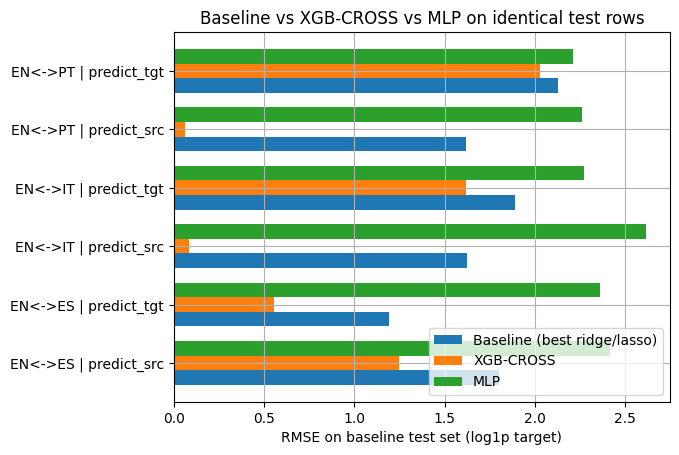

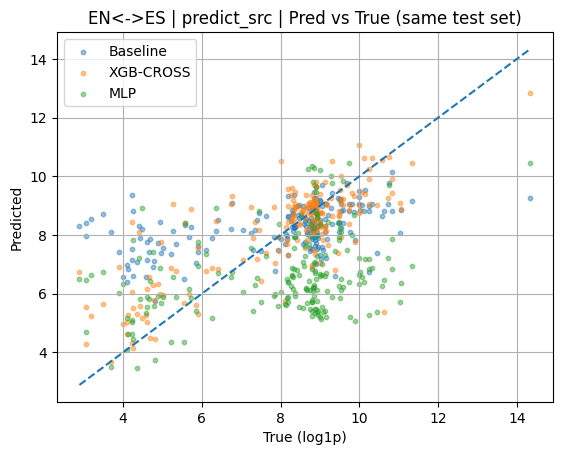

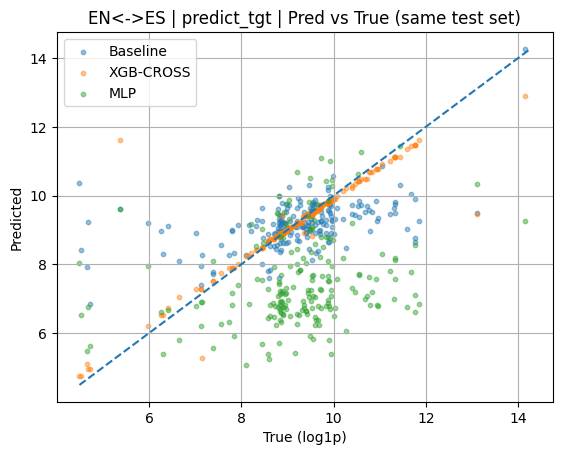

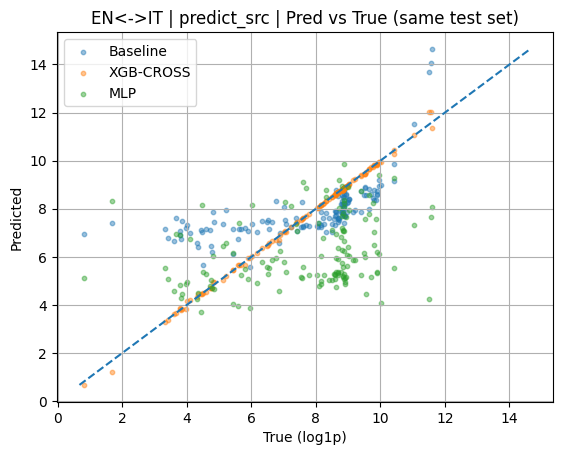

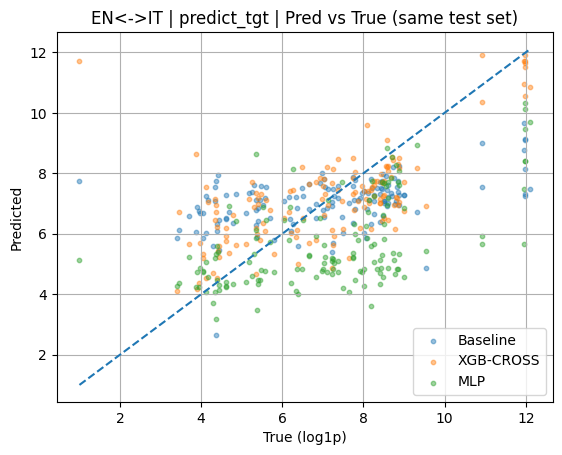

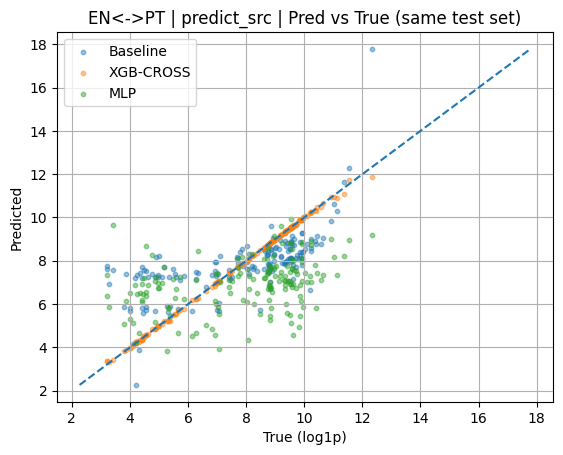

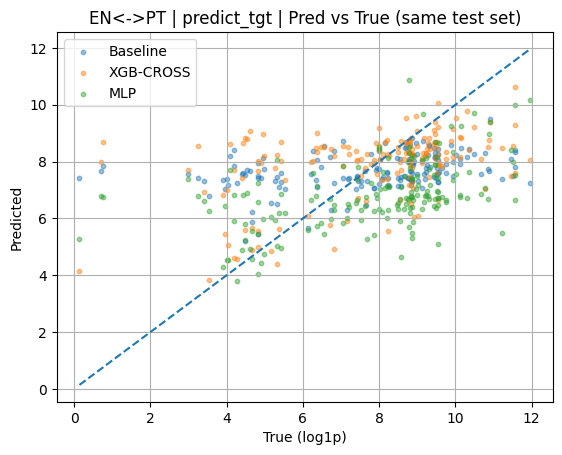

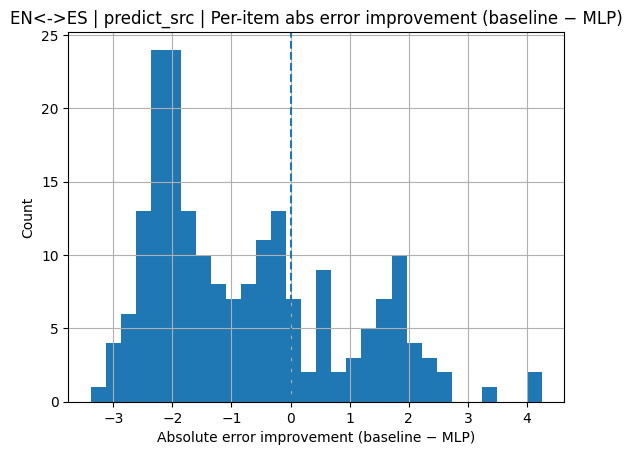

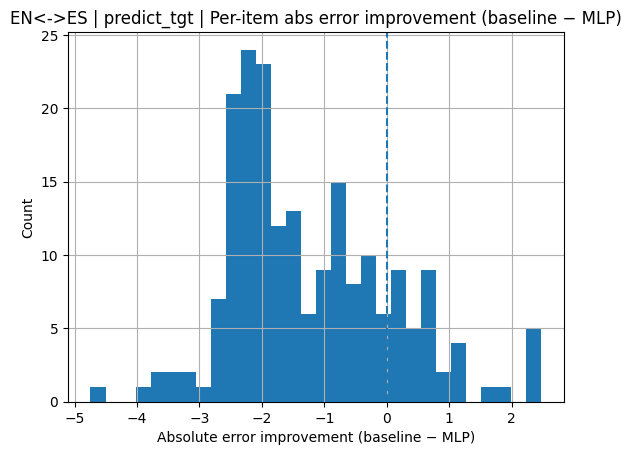

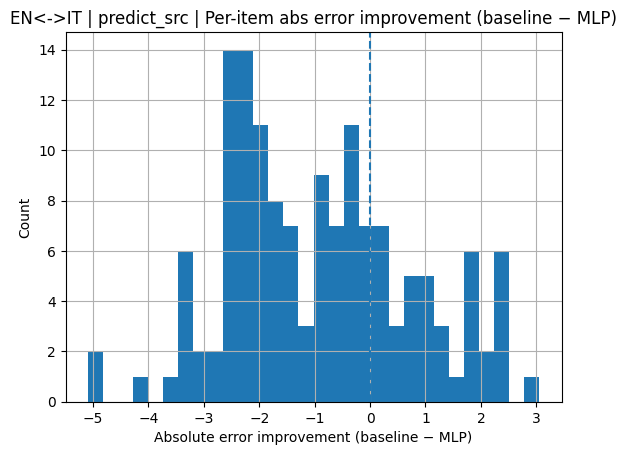

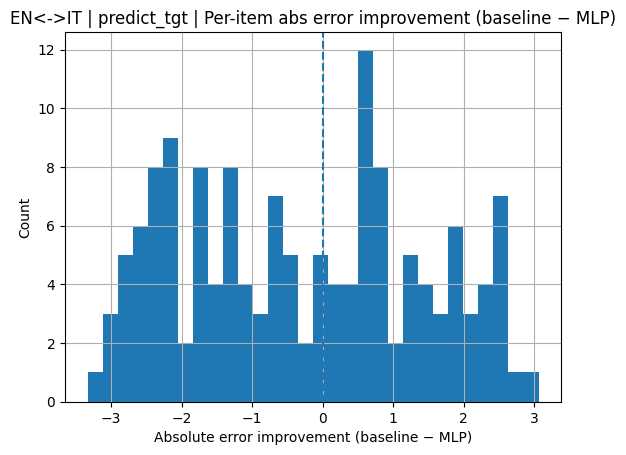

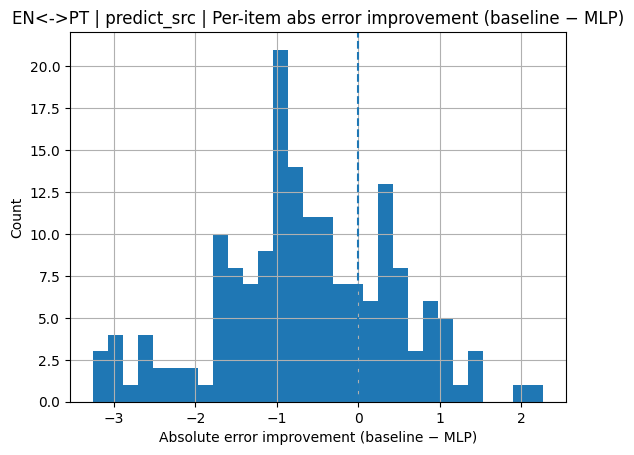

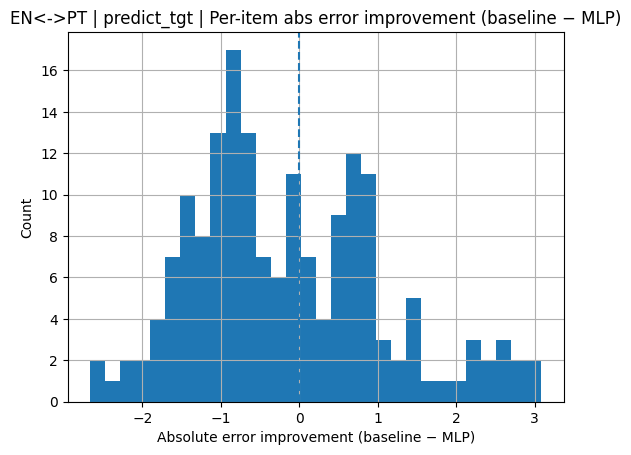

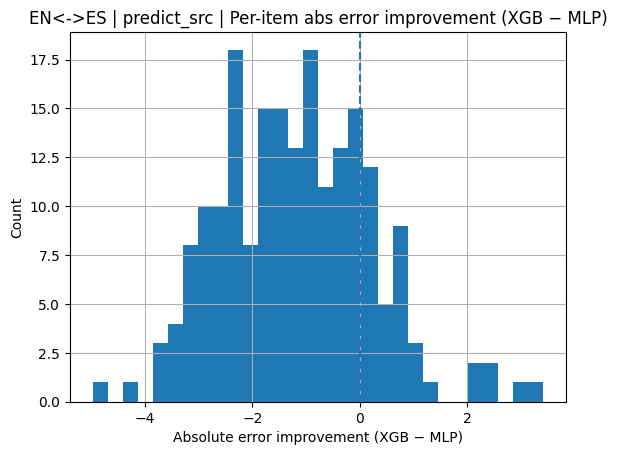

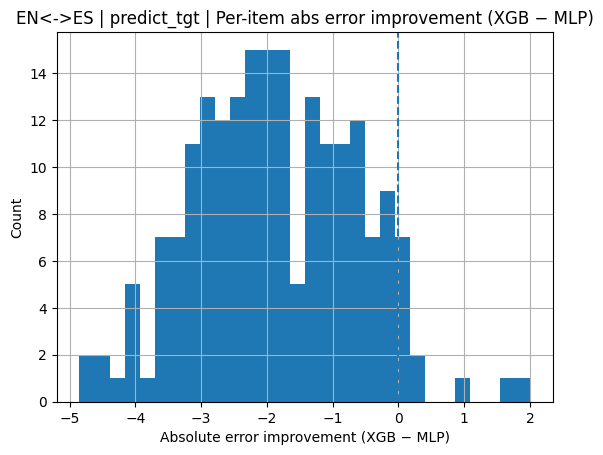

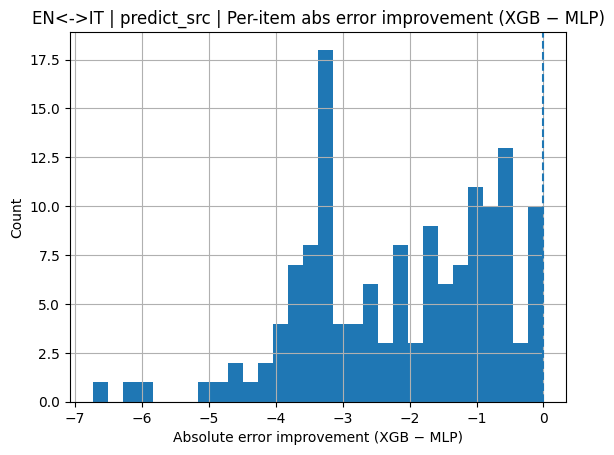

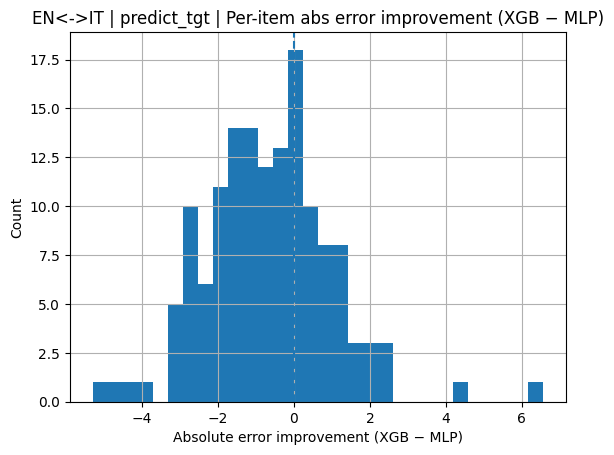

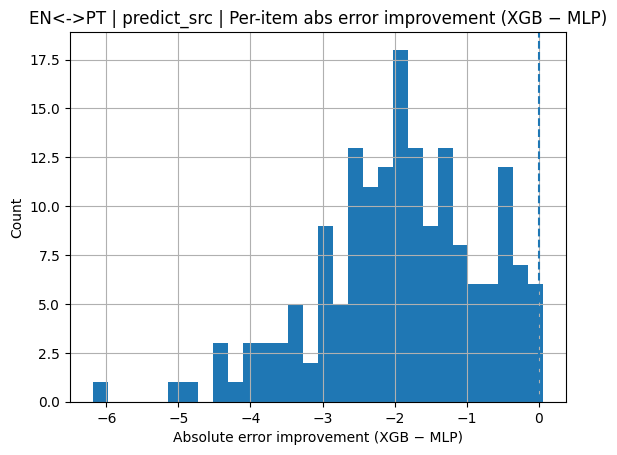

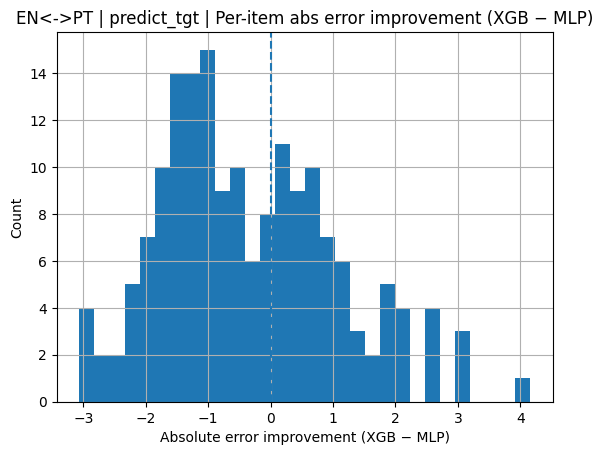

C:\Users\paolo\AppData\Local\Temp\ipykernel_29380\386425292.py:60: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda d: pd.Series({


,pair,task,mlp_win_rate_vs_baseline,mlp_win_rate_vs_xgb
0,EN<->ES,predict_src,0.266332,0.195980
1,EN<->ES,predict_tgt,0.195980,0.045226
2,EN<->IT,predict_src,0.298611,0.006944
3,EN<->IT,predict_tgt,0.458333,0.347222
4,EN<->PT,predict_src,0.292398,0.011696
5,EN<->PT,predict_tgt,0.397661,0.397661


In [20]:
labels = (eval_3["pair"] + " | " + eval_3["task"]).tolist()
y_base = eval_3["baseline_rmse"].to_numpy()
y_xgb  = eval_3["xgb_rmse"].to_numpy()
y_mlp  = eval_3["mlp_rmse"].to_numpy()

plt.figure()
y_pos = np.arange(len(labels))
plt.barh(y_pos - 0.25, y_base, height=0.25, label="Baseline (best ridge/lasso)")
plt.barh(y_pos + 0.00, y_xgb,  height=0.25, label="XGB-CROSS")
plt.barh(y_pos + 0.25, y_mlp,  height=0.25, label="MLP")
plt.yticks(y_pos, labels)
plt.xlabel("RMSE on baseline test set (log1p target)")
plt.title("Baseline vs XGB-CROSS vs MLP on identical test rows")
plt.legend()
plt.grid(True)
plt.show()


for (pair, task), df_g in pred_3.groupby(["pair","task"]):
    plt.figure()
    plt.scatter(df_g["y_true"], df_g["y_pred_base"], s=10, alpha=0.45, label="Baseline")
    plt.scatter(df_g["y_true"], df_g["y_pred_xgb"],  s=10, alpha=0.45, label="XGB-CROSS")
    plt.scatter(df_g["y_true"], df_g["y_pred_mlp"],  s=10, alpha=0.45, label="MLP")
    mn = min(df_g["y_true"].min(), df_g["y_pred_base"].min(), df_g["y_pred_xgb"].min(), df_g["y_pred_mlp"].min())
    mx = max(df_g["y_true"].max(), df_g["y_pred_base"].max(), df_g["y_pred_xgb"].max(), df_g["y_pred_mlp"].max())
    plt.plot([mn, mx], [mn, mx], linestyle="--")
    plt.xlabel("True (log1p)")
    plt.ylabel("Predicted")
    plt.title(f"{pair} | {task} | Pred vs True (same test set)")
    plt.legend()
    plt.grid(True)
    plt.show()



for (pair, task), df_g in pred_3.groupby(["pair","task"]):
    plt.figure()
    plt.hist(df_g["abs_err_improvement_base_minus_mlp"], bins=30)
    plt.axvline(0, linestyle="--")
    plt.xlabel("Absolute error improvement (baseline − MLP)")
    plt.ylabel("Count")
    plt.title(f"{pair} | {task} | Per-item abs error improvement (baseline − MLP)")
    plt.grid(True)
    plt.show()

for (pair, task), df_g in pred_3.groupby(["pair","task"]):
    plt.figure()
    plt.hist(df_g["abs_err_improvement_xgb_minus_mlp"], bins=30)
    plt.axvline(0, linestyle="--")
    plt.xlabel("Absolute error improvement (XGB − MLP)")
    plt.ylabel("Count")
    plt.title(f"{pair} | {task} | Per-item abs error improvement (XGB − MLP)")
    plt.grid(True)
    plt.show()



win_rates = (
    pred_3.groupby(["pair","task"])
          .apply(lambda d: pd.Series({
              "mlp_win_rate_vs_baseline": (d["abs_err_improvement_base_minus_mlp"] > 0).mean(),
              "mlp_win_rate_vs_xgb":      (d["abs_err_improvement_xgb_minus_mlp"]  > 0).mean(),
          }))
          .reset_index()
)
display(win_rates)
